In [ ]:
'''
VIPLAB 비전 네트워크 구조 스터디
2024.03.12 / 1회차
작성자 : 이예준
연락 : dldpwns001@gachon.ac.kr
'''

In [ ]:
## 소스 출처 : https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

## Pytorch 기반 네트워크 구조 학습
## 1. Torchvision 기능을 통해서 미리 정의된 데이터 세트를 불러온다(CIFAR10).
## 2. 간단한 커스텀 CNN을 정의한다.
## 3. 네트워크 학습에 필요한 적절한 손실 함수를 정의한다.
## 4. CIFAR10 데이터 세트로 모델을 학습하고 평가한다.

## 5. 커스텀 데이터 세트를 정의한다(전처리, 커스텀 데이터 세트 선언, 전처리된 데이터 불러오기).
## 6. 커스텀 데이터 세트로 모델을 학습하고 평가한다.

In [ ]:
# 필요한 라이브러리 로드
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import glob
import pickle
from PIL import Image
import torch.utils.data as data

In [ ]:
# 이미지 처리를 위한 transform을 정의(img to tensor + normalization)
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# CIFAR10 간단한 Convolution 기반 네트워크를 정의
class CIFAR_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


**torchvision 기능을 통해서 데이터 세트를 불러오고 학습해보자**
-------------------------------------

In [ ]:
# class로 정의한 네트워크를 instance로 호출
cifar_net = CIFAR_Net()
print(cifar_net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Loss function, Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_net.parameters(), lr=0.001, momentum=0.9) #여기서 net.parameters()는 'net' 모델에 존재하는 모든 파라미터를 호출하는 함수

In [ ]:
## torchvision 라이브러리를 통해서 미리 정의된 데이터 셋 불러오기

# dataloader 정의에 필요한 batchsize 정의
batch_size = 4

# 학습 데이터 세트 및 데이터 로더 정의
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# 테스트 데이터 세트 및 데이터 로더 정의
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# CIFAR-10 데이터셋에 존재하는 class 이름을 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


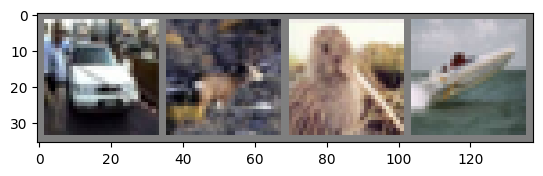

car   deer  bird  ship 


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 학습을 진행합니다
epochs = 2

for epoch in range(epochs):   # 데이터셋 학습을 epochs 만큼 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = cifar_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.153
[1,  4000] loss: 1.836
[1,  6000] loss: 1.649
[1,  8000] loss: 1.550
[1, 10000] loss: 1.492
[1, 12000] loss: 1.436
[2,  2000] loss: 1.381
[2,  4000] loss: 1.332
[2,  6000] loss: 1.333
[2,  8000] loss: 1.301
[2, 10000] loss: 1.272
[2, 12000] loss: 1.286
Finished Training


In [ ]:
## 학습된 결과를 확인합니다(전체)

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = cifar_net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
## 학습된 결과를 확인합니다(클래스 별)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cifar_net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.2 %
Accuracy for class: car   is 72.7 %
Accuracy for class: bird  is 33.2 %
Accuracy for class: cat   is 28.6 %
Accuracy for class: deer  is 44.1 %
Accuracy for class: dog   is 51.6 %
Accuracy for class: frog  is 76.5 %
Accuracy for class: horse is 71.6 %
Accuracy for class: ship  is 53.4 %
Accuracy for class: truck is 61.9 %


**커스텀 데이터 세트를 구축해보자**
--------------------------------------------------------------------

In [ ]:
# 커스텀 데이터 세트를 구성하기 위한 Stanford40 데이터 세트를 다운로드하고 압축해제
!wget http://vision.stanford.edu/Datasets/Stanford40.zip
!unzip -qq './Stanford40.zip' -d './Stanford40'

--2024-03-11 07:19:40--  http://vision.stanford.edu/Datasets/Stanford40.zip
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 308432833 (294M) [application/zip]
Saving to: ‘Stanford40.zip’

Stanford40.zip      100%[===================>] 294.14M  16.3MB/s    in 20s     

2024-03-11 07:20:00 (14.8 MB/s) - ‘Stanford40.zip’ saved [308432833/308432833]



In [ ]:
## Stanford40 데이터 세트의 구조를 이해해야합니다.
# ./Stanford40/ImageSplits : .txt 파일로 annotation을 진행한 폴더
# ./Stanford40/JPEGImages : 데이터 셋의 이미지가 존재하는 폴더
# ./Stanford40/MatlabAnnotations : .mat 파일로 annotation을 진행한 폴더
# ./Stanford40/XMLAnnotations : .xml 파일로 annotation을 진행한 폴더

# 여기서 우리는 txt 파일로 커스텀 데이터 세트를 만들고 불러오겠습니다.
train_txt_root = '/content/Stanford40/train_set.txt'
test_txt_root = '/content/Stanford40/test_set.txt'

# Stanford40 dataset classes
classes = \
 ['applauding','blowing_bubbles','brushing_teeth','cleaning_the_floor','climbing',
'cooking','cutting_trees','cutting_vegetables','drinking','feeding_a_horse',
'fishing','fixing_a_bike','fixing_a_car','gardening','holding_an_umbrella',
'jumping','looking_through_a_microscope','looking_through_a_telescope','playing_guitar','playing_violin',
'pouring_liquid','pushing_a_cart','reading','phoning','riding_a_bike',
'riding_a_horse','rowing_a_boat','running','shooting_an_arrow','smoking',
'taking_photos','texting_message','throwing_frisby','using_a_computer','walking_the_dog',
'washing_dishes','watching_TV','waving_hands','writing_on_a_board','writing_on_a_book'
]

# 전처리에 대한 자세한 설명은 네트워크 구조 스터디 ppt를 참고해주세요
# 총 두가지 버전으로 전처리를 해봅니다
# .txt 파일로 전처리하기
# .pkl 파일로 전처리하기
if not os.path.isfile(train_txt_root):
  train_link = glob.glob('/content/Stanford40/ImageSplits/*_train.txt')
  train_list = []
  train_label = []
  train_dict = {}

  for txt in train_link:
      with open(txt,'r') as file:
          temp = file.readlines()
          temp_list = []
          for text in temp:
              train_list.append(text[:-1])
  with open(train_txt_root,"w") as train_txt:
    for data_name in train_list:
        for idx, name in enumerate(classes):
          if name == data_name[:-8]:
              train_label.append(idx)
              data = f"{data_name} {idx}\n"
              train_txt.write(data)
              continue
  print('train_set.txt is created')

  train_dict['image_name'] = train_list
  train_dict['label'] = train_label

  with open('/content/Stanford40/train_set.pkl', 'wb') as f:
    pickle.dump(train_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  print('train_set.pkl is created')

if not os.path.isfile(test_txt_root):
  test_link = glob.glob('/content/Stanford40/ImageSplits/*_test.txt')
  test_list = []
  test_label = []
  test_dict = {}

  for txt in test_link:
      with open(txt,'r') as file:
          temp = file.readlines()
          temp_list = []
          for text in temp:
              test_list.append(text[:-1])
  with open(test_txt_root,"w") as test_txt:
    for data_name in test_list:
        for idx, name in enumerate(classes):
          if name == data_name[:-8]:
              test_label.append(idx)
              data = f"{data_name} {idx}\n"
              test_txt.write(data)
              continue
  print('test_set.txt is created')

  test_dict['image_name'] = test_list
  test_dict['label'] = test_label

  with open('/content/Stanford40/test_set.pkl', 'wb') as f:
    pickle.dump(test_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  print('test_set.pkl is created')

In [ ]:
root = '/content/Stanford40/train_set.pkl'

with open(root, 'rb') as f:
  data = pickle.load(f)

print(data['image_name'])
print(data['label'])

['fixing_a_bike_098.jpg', 'fixing_a_bike_080.jpg', 'fixing_a_bike_204.jpg', 'fixing_a_bike_183.jpg', 'fixing_a_bike_069.jpg', 'fixing_a_bike_022.jpg', 'fixing_a_bike_027.jpg', 'fixing_a_bike_047.jpg', 'fixing_a_bike_211.jpg', 'fixing_a_bike_111.jpg', 'fixing_a_bike_227.jpg', 'fixing_a_bike_013.jpg', 'fixing_a_bike_145.jpg', 'fixing_a_bike_003.jpg', 'fixing_a_bike_023.jpg', 'fixing_a_bike_045.jpg', 'fixing_a_bike_142.jpg', 'fixing_a_bike_138.jpg', 'fixing_a_bike_061.jpg', 'fixing_a_bike_191.jpg', 'fixing_a_bike_117.jpg', 'fixing_a_bike_060.jpg', 'fixing_a_bike_085.jpg', 'fixing_a_bike_112.jpg', 'fixing_a_bike_219.jpg', 'fixing_a_bike_114.jpg', 'fixing_a_bike_115.jpg', 'fixing_a_bike_063.jpg', 'fixing_a_bike_035.jpg', 'fixing_a_bike_037.jpg', 'fixing_a_bike_161.jpg', 'fixing_a_bike_021.jpg', 'fixing_a_bike_105.jpg', 'fixing_a_bike_099.jpg', 'fixing_a_bike_072.jpg', 'fixing_a_bike_201.jpg', 'fixing_a_bike_225.jpg', 'fixing_a_bike_078.jpg', 'fixing_a_bike_162.jpg', 'fixing_a_bike_079.jpg',

In [ ]:
# 커스텀 데이터 셋을 정의합니다
class CustomDataset(data.Dataset):
    # 데이터 셋을 처음 불러올 때 사용되는 __init__ 함수는 데이터 셋을 구성하는데 필요한 요소를 선언하는데 사용됩니다.
    def __init__(self, transform, root):
      super(CustomDataset, self).__init__()

      self.path = '/content/Stanford40/JPEGImages/'
      self.transform = transform

      if 'pkl' in root:
        print('pkl로 데이터를 불러옵니다')
        with open(root, 'rb') as f:
          data = pickle.load(f)

        self.image_name = data['image_name']
        self.label = data['label']
      elif 'txt' in root:
        print('txt로 데이터를 불러옵니다')
        with open(root, 'rb') as f:
          data = f.readlines()
          data_name = []
          data_label = []
          for text in data:
            split = text.split()
            data_name.append(str(split[0].decode("utf-8") ))
            data_label.append(int(split[1].decode("utf-8") ))

        self.image_name = data_name
        self.label = data_label

    # 데이터 셋의 전체 크기를 반환하는 함수
    def __len__(self):
      return len(self.image_name)

    # 데이터 셋이 특정 index에 대해서 데이터를 반환해주는 함수(dataloader에 의해서 관리된다)
    def __getitem__(self, index):
      img = Image.open(self.path+self.image_name[index]).convert('RGB')

      if self.transform is not None:
          img = self.transform(img)

      label = self.label[index]

      return img, label

In [ ]:
# 이미지 처리를 위한 transform을 정의(img to tensor + normalization)
stanford_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32),antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
## custom dataset을 선언하고 dataloader에 올리기
train_txt_root = '/content/Stanford40/train_set.txt'
train_pkl_root = '/content/Stanford40/train_set.pkl'
test_txt_root = '/content/Stanford40/test_set.txt'
test_pkl_root = '/content/Stanford40/test_set.pkl'


# dataloader 정의에 필요한 batchsize 정의
batch_size = 4

# txt와 pkl를 모두 비교하기 위해서 총 4개의 데이터 세트 및 로더 만들기
train_txt_set = CustomDataset(stanford_transform, train_txt_root)
train_pkl_set = CustomDataset(stanford_transform, train_pkl_root)
test_txt_set = CustomDataset(stanford_transform, test_txt_root)
test_pkl_set = CustomDataset(stanford_transform, test_pkl_root)

train_txt_dataloader = torch.utils.data.DataLoader(train_txt_set, batch_size=batch_size, shuffle=True, num_workers=2)
train_pkl_dataloader = torch.utils.data.DataLoader(train_pkl_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_txt_dataloader = torch.utils.data.DataLoader(test_txt_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_pkl_dataloader = torch.utils.data.DataLoader(test_pkl_set, batch_size=batch_size, shuffle=False, num_workers=2)

txt로 데이터를 불러옵니다
pkl로 데이터를 불러옵니다
txt로 데이터를 불러옵니다
pkl로 데이터를 불러옵니다


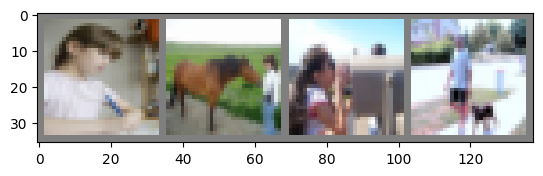

writing_on_a_book feeding_a_horse looking_through_a_telescope walking_the_dog


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_pkl_dataloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# Stanford40 간단한 Convolution 기반 네트워크를 정의
class Stanford_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
stanford_net = Stanford_Net()
print(stanford_net)

Stanford_Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
)


In [ ]:
# Loss function, Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(stanford_net.parameters(), lr=0.001, momentum=0.9) #여기서 net.parameters()는 'net' 모델에 존재하는 모든 파라미터를 호출하는 함수

In [ ]:
# 학습을 진행합니다
epochs = 2

for epoch in range(epochs):   # 데이터셋 학습을 epochs 만큼 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_txt_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = stanford_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
## 학습된 결과를 확인합니다(전체)

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_pkl_dataloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = stanford_net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 3 %


In [ ]:
## 학습된 결과를 확인합니다(클래스 별)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in test_pkl_dataloader:
        images, labels = data
        outputs = stanford_net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: applauding is 0.0 %
Accuracy for class: blowing_bubbles is 0.0 %
Accuracy for class: brushing_teeth is 0.0 %
Accuracy for class: cleaning_the_floor is 0.0 %
Accuracy for class: climbing is 0.0 %
Accuracy for class: cooking is 0.0 %
Accuracy for class: cutting_trees is 0.0 %
Accuracy for class: cutting_vegetables is 0.0 %
Accuracy for class: drinking is 0.0 %
Accuracy for class: feeding_a_horse is 0.0 %
Accuracy for class: fishing is 0.0 %
Accuracy for class: fixing_a_bike is 0.8 %
Accuracy for class: fixing_a_car is 0.0 %
Accuracy for class: gardening is 0.0 %
Accuracy for class: holding_an_umbrella is 0.0 %
Accuracy for class: jumping is 0.0 %
Accuracy for class: looking_through_a_microscope is 7.7 %
Accuracy for class: looking_through_a_telescope is 3.9 %
Accuracy for class: playing_guitar is 4.8 %
Accuracy for class: playing_violin is 0.0 %
Accuracy for class: pouring_liquid is 0.0 %
Accuracy for class: pushing_a_cart is 0.0 %
Accuracy for class: reading is 0.0 %